In [1]:
import pyvista as pv
from linetimer import CodeTimer

In [28]:

import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from BabelViscoFDTD.tools.RayleighAndBHTE import GenerateFocusTx,SpeedofSoundWater, GenerateSurface,InitMetal,ForwardSimple,InitOpenCL
from BabelViscoFDTD.H5pySimple import SaveToH5py,ReadFromH5py
from BabelIntegrationBASE import Material

InitMetal('M3')
import os


extlay={}
TemperatureWater=37.0
extlay['c']=SpeedofSoundWater(TemperatureWater)



def computeExaNeuroGeometry():
    # transxyz = np.loadtxt(os.path.join(os.path.dirname(os.path.realpath(__file__)),'ExaNeuroTransducerGeometry.csv'),delimiter=',',skiprows=0)
    transxyz = np.loadtxt(os.path.join('.','ExaNeuroTransducerGeometry.csv'),delimiter=',',skiprows=0)
    assert(transxyz.shape[0]==1024) #number of elements
    assert(transxyz.shape[1]==4) #element, X,Y,Z coordinates in mm, and area in mm2
    transxyz=transxyz[:,:3] #we skip the Tx element coordinates only
    return transxyz*1e-3

DimensionElem = np.sqrt(113.54)*1e-3
DimensionElem = 10e-3
FREQ=650e3

def GenerateSingleElem(PPW=12.0,Foc=150e-3):
    #60.08 PPW produces close to integer steps for both pitch and kerf
    
    Tx = {}

    step = 1500/FREQ/PPW
    hstep=step/2.0
    latSteps=int(np.round(DimensionElem/step))
    print('latSteps',latSteps)
    step=DimensionElem/latSteps

    centersX= np.arange(latSteps)*step
    centersX-=np.mean(centersX)

    SingElem = np.zeros((latSteps**2,3))
    N = np.zeros((SingElem.shape[0],3))
    N[:,2]=1
    ds = np.ones((SingElem.shape[0],1))*step**2

    VertDisplay=  np.zeros((SingElem.shape[0]*4,3))
    FaceDisplay= np.arange(SingElem.shape[0]*4,dtype=int).reshape((SingElem.shape[0],4))

    XX,YY=np.meshgrid(centersX,centersX)
    SingElem[:,0]=XX.flatten()
    SingElem[:,1]=YY.flatten()
    SingElem[:,2]=-Foc

    VertDisplay[0::4,0]=SingElem[:,0]-hstep
    VertDisplay[0::4,1]=SingElem[:,1]-hstep
    
    VertDisplay[1::4,0]=SingElem[:,0]+hstep
    VertDisplay[1::4,1]=SingElem[:,1]-hstep

    VertDisplay[2::4,0]=SingElem[:,0]+hstep
    VertDisplay[2::4,1]=SingElem[:,1]+hstep

    VertDisplay[3::4,0]=SingElem[:,0]-hstep
    VertDisplay[3::4,1]=SingElem[:,1]+hstep

    VertDisplay[:,2]=-Foc

   
    Tx['center'] = SingElem 
    Tx['ds'] = ds
    Tx['normal'] = N
    Tx['VertDisplay'] = VertDisplay 
    Tx['FaceDisplay'] = FaceDisplay 
    return Tx

def GenerateExaNeuroTx(Frequency=220e3,RotationZ=0,FactorEnlarge=1):

    f=Frequency;
    Foc=150e-3*FactorEnlarge
    Diameter=10e-3*FactorEnlarge

    #%This is the indiv tx element
    # TxElem=GenerateSingleElem()
    TxElem=GenerateFocusTx(f,Foc,Diameter,extlay['c'],PPWSurface=6)

    transLoc = computeExaNeuroGeometry()
    # transLoc=transLoc[[0,1023],:]
  
    transLocDisplacedZ=transLoc.copy()
    transLocDisplacedZ[:,2]-=Foc
    # print(transLocDisplacedZ)
    NElems=transLoc.shape[0]
    nSubElems=len( TxElem['ds'])
   
    nSubElemsVert=TxElem['VertDisplay'].shape[0]
    # print('nSubElemsVert',nSubElemsVert)

    XYNorm=np.linalg.norm(transLocDisplacedZ[:,:2],axis=1)
    VN=np.linalg.norm(transLocDisplacedZ,axis=1)
    theta=np.arcsin(XYNorm/VN)
    phi=np.arctan2(transLocDisplacedZ[:,1],transLocDisplacedZ[:,0])
    phi+=np.deg2rad(RotationZ)
    # print('theta',theta)
    # print('phi',phi)

    TxExaNeuro={}
    TxExaNeuro['center'] = np.zeros((nSubElems*NElems,3))
    TxExaNeuro['elemcenter'] = np.zeros((len(theta),3))
    TxExaNeuro['ds'] = np.zeros((nSubElems*NElems,1))
    TxExaNeuro['normal'] = np.zeros((nSubElems*NElems,3))
    TxExaNeuro['elemdims']=TxElem['ds'].size
    TxExaNeuro['NumberElems']=len(theta)
    TxExaNeuro['VertDisplay'] = np.zeros((nSubElemsVert*NElems,3))
    TxExaNeuro['FaceDisplay'] = np.zeros((nSubElems*NElems,4),np.int64)

    for n in range(len(theta)):
        rotateMatrixY = np.array([[np.cos(theta[n]),0,np.sin(theta[n])],[0,1,0],[-np.sin(theta[n]),0,np.cos(theta[n])]])
        rotateMatrixZ = np.array([[-np.cos(phi[n]),np.sin(phi[n]),0],[-np.sin(phi[n]),-np.cos(phi[n]),0],[0,0,1]])
        rotateMatrix = rotateMatrixZ@rotateMatrixY
       
        center=(rotateMatrix@TxElem['center'].T).T
        TxExaNeuro['elemcenter'][n,:]=np.mean(center,axis=0) # the very first subelement is at the center
        
        normal=(rotateMatrix@TxElem['normal'].T).T

        VertDisplay=(rotateMatrix@TxElem['VertDisplay'].T).T
       
        TxExaNeuro['center'][n*nSubElems:(n+1)*nSubElems,:]=center
        TxExaNeuro['ds'][n*nSubElems:(n+1)*nSubElems]=TxElem['ds']
        TxExaNeuro['normal'][n*nSubElems:(n+1)*nSubElems,:]=normal
        TxExaNeuro['VertDisplay'][n*nSubElemsVert:(n+1)*nSubElemsVert,:]=VertDisplay
        TxExaNeuro['FaceDisplay'][n*nSubElems:(n+1)*nSubElems,:]=TxElem['FaceDisplay']+n*nSubElemsVert

    TxExaNeuro['VertDisplay'][:,2]
    TxExaNeuro['center'][:,2]
    TxExaNeuro['elemcenter'][:,2]
    
    print('Aperture dimensions (x,y) =',TxExaNeuro['center'][:,0].max()-TxExaNeuro['center'][:,0].min(),
                                        TxExaNeuro['center'][:,1].max()-TxExaNeuro['center'][:,1].min())

    print('Aperture dimensions (x,y) =',TxExaNeuro['VertDisplay'][:,0].max()-TxExaNeuro['VertDisplay'][:,0].min(),
                                        TxExaNeuro['VertDisplay'][:,1].max()-TxExaNeuro['VertDisplay'][:,1].min())


    TxExaNeuro['FocalLength']=Foc
    TxExaNeuro['Aperture']=np.max([TxExaNeuro['VertDisplay'][:,0].max()-TxExaNeuro['VertDisplay'][:,0].min(),
                                      TxExaNeuro['VertDisplay'][:,1].max()-TxExaNeuro['VertDisplay'][:,1].min()]);
    return TxExaNeuro


Iniitalizing BHTE code MetalCompute
Selecting device:  Apple M3 Max
metalcompute.Device(Apple M3 Max)


In [29]:
Tx=GenerateExaNeuroTx()
Tx['center'].max(axis=0)

Aperture dimensions (x,y) = 0.2997350887446102 0.299841583560063
Aperture dimensions (x,y) = 0.29977489067842295 0.2998662878112298


array([ 0.14985398,  0.1498509 , -0.00138966])

In [30]:

Faces=np.hstack((np.ones((Tx['FaceDisplay'].shape[0],1),int)*4,Tx['FaceDisplay'])) 
mesh = pv.PolyData(Tx['VertDisplay'],Faces)
# Plot using the ITKplotter
pv.plot(mesh,color='r')

Widget(value='<iframe src="http://localhost:49576/index.html?ui=P_0x35b6d5d00_1&reconnect=auto" class="pyvista…

In [5]:
# from stl import mesh
# #we also export the STL of the Tx for display in Brainsight or 3D slicer
# TxVert=Tx['VertDisplay'].T.copy()

# TxStl = mesh.Mesh(np.zeros(Tx['FaceDisplay'].shape[0]*2, dtype=mesh.Mesh.dtype))

# TxVert=TxVert.T[:,:3]
# for i, f in enumerate(Tx['FaceDisplay']):
#     TxStl.vectors[i*2][0] = TxVert[f[0],:]
#     TxStl.vectors[i*2][1] = TxVert[f[1],:]
#     TxStl.vectors[i*2][2] = TxVert[f[3],:]

#     TxStl.vectors[i*2+1][0] = TxVert[f[1],:]
#     TxStl.vectors[i*2+1][1] = TxVert[f[2],:]
#     TxStl.vectors[i*2+1][2] = TxVert[f[3],:]

# TxStl.save('Tx.stl')

In [5]:
Tx['VertDisplay'].min(axis=0),Tx['VertDisplay'].max(axis=0)

(array([-0.14990112, -0.14999539, -0.14999253]),
 array([ 0.14987516,  0.14987255, -0.00088958]))

In [39]:
Frequency=220e3
Step=1500/Frequency/9
Nsteps=int(np.round(32e-2/Step))
if Nsteps%2==0:
    Nsteps+=1
xl=np.arange(Nsteps).astype(np.float32)
xl-=np.mean(xl)
xl*=Step
yl=np.array([0.0]).astype(np.float32)
zl = np.arange(-16e-2,4e-2,Step).astype(np.float32)
xx,yy,zz=np.meshgrid(xl,yl,zl,indexing='ij')
rf=np.vstack((xx.flatten(),yy.flatten(),zz.flatten())).T.astype(np.float32)


cwvnb_extlay=np.array(2*np.pi*Frequency/Material['Water'][1]+1j*0).astype(np.complex64)
u0=np.ones((Tx['center'].shape[0],1),np.complex64)
with CodeTimer('Rayleigh cost',unit='s'): 
    u2=ForwardSimple(cwvnb_extlay,Tx['center'].astype(np.float32),Tx['ds'].astype(np.float32),u0,rf,deviceMetal='M3')




Code block 'Rayleigh cost' took: 0.08622 s


In [33]:
SaveToH5py({'u2':u2},'/Users/spichardo/Documents/TestU2Exablate.h5')

(423, 1, 264)

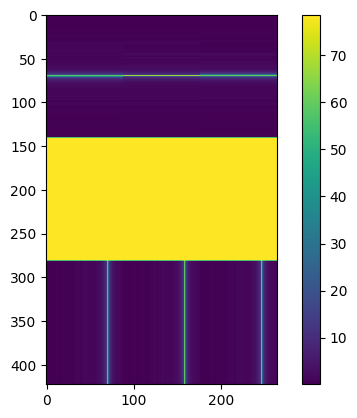

In [40]:
u2a=np.abs(u2).reshape(xx.shape)
plt.imshow(u2a[:,0,:])
plt.colorbar()
u2a.shape

In [38]:
u0.dtype

dtype('complex64')

In [15]:
nxf=len(xl)
nyf=len(yl)
nzf=len(zl)
rf=np.hstack((np.reshape(xx,(nxf*nyf*nzf,1)),np.reshape(yy,(nxf*nyf*nzf,1)), np.reshape(zz,(nxf*nyf*nzf,1)))).astype(np.float32)

In [17]:
rf.shape,nxf,nyf,nzf

((100674, 3), 423, 1, 238)

True